# Viterbi Decoding and ML Sequence Detection
###  Liu Cao

Viterbi decoding is used to decode a bitstream that was generated by a convolutional encoder, finding the most-likely sequence of hidden states from a sequence of observed events, in the context of hidden Markov models. In other words, in a communication system, for example, the transceiver encodes the desired bits to be transferred, preparing the encoded bitstream for an unfortunate data change caused by the channel noise. The receiver decoder knows the state machine created by the encoder hardware, which can find the most-likely transmitted bits based on the most-likely path.

## Convolutional Encoding

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import pickle

def v_xor(bit0, bit1):
    if (bit0==bit1):
        return "0"
    else:
        return "1"
    
def calcMetric(num_1, num_2):
    count = 0;
    for i in range(0, len(num_1), 1):
        if (num_1[i]!=num_2[i]):
            count += 1
    return count
    
def convEncoder(codeOri):
    chainConv = ["0", "0", "0"]
    codeConv = []
    codeTrans = []
    for t in range (0,len(codeOri)):
        chainConv[2] = chainConv[1]
        chainConv[1] = chainConv[0]
        chainConv[0] = str(codeOri[t])
        state = chainConv[0] + chainConv[1]

        codeConv.append(v_xor(v_xor(chainConv[0], chainConv[1]), chainConv[2])+\
            v_xor(chainConv[0], chainConv[2]))
        codeTrans.append(int(v_xor(v_xor(chainConv[0], chainConv[1]), chainConv[2])))
        codeTrans.append(int(v_xor(chainConv[0], chainConv[2])))
        
    return codeConv, codeTrans

In [15]:
# An example for convolutional encoding
print(">>>>> Convolutional Encoder <<<<<")
Bitstream = [0, 0, 1, 0, 1, 1, 0, 0, 1, 0]
codeConv, codeTransT = convEncoder(Bitstream)
print("Original bitstream:", Bitstream)
print('Convolutional codes:', codeConv)

>>>>> Convolutional Encoder <<<<<
Original bitstream: [0, 0, 1, 0, 1, 1, 0, 0, 1, 0]
Convolutional codes: ['00', '00', '11', '10', '00', '01', '01', '11', '11', '10']


## Viterbi Decoding

### Maximum Likelihood Decoding

The Viterbi decoding method uses the maximum likelihood decoding (MLD). In maximum likelihood decoding, the received word is compared to all the possible code words. The one code word that is closest is then the error corrected code word. The name describes the most important property of this decoding. If an error is detected, then we identify the most probable error and undo this error in order to correct the mistake. Sometimes of course we will make a mistake in guessing the error. As an example for maximum likelihood encoding we assume the following pairing between data words and code words: 

$00  \quad 00100$

$01  \quad 01110$

$10  \quad 10001$

$11  \quad 11000$

Assume now that we receive the word 11111. By going through all code words in the list, we find that none matches. Hence, a transmission error has occurred. The Hamming distances to the code words are d(11111,00100) = 4, d(11111,01110) =2, d(11111,10001) = 3, and d(11111,11000) = 3. We therefore conclude that the first and last bit are in error and that we should have received 01110, which corresponds to message 01.

### Viterbi Decoding

In [12]:
# State machine which describe the state transitions in the encoding system.
start_metric = {'zero':0, 'one': 0, 'two': 0, 'three':0}
# zero = "00", one = "01", two = "10", three = "11"
state_machine = {
    'zero':{'b1':{'out_b':"11", 'prev_st':'one', 'input_b':0},
            'b2':{'out_b':"00", 'prev_st':'zero', 'input_b':0}},
    'one':{'b1':{'out_b':"01", 'prev_st':'three', 'input_b':0},
           'b2':{'out_b':"10", 'prev_st':'two', 'input_b':0}},
    'two':{'b1':{'out_b':"11", 'prev_st':'zero', 'input_b':1},
           'b2':{'out_b':"00", 'prev_st':'one', 'input_b':1}},
    'three':{'b1':{'out_b':"10", 'prev_st':'three', 'input_b':1},
             'b2':{'out_b':"01", 'prev_st':'two', 'input_b':1}},
}

# Viterbi decoder
def vitDec(obs, start_metric, state_machine):
    V = [{}]
    for st in state_machine:
        V[0][st] = {"metric": start_metric[st]}
    for t in range(1, len(obs)+1):
        V.append({})
        for st in state_machine:
            prev_st = state_machine[st]['b1']['prev_st']
            first_b_metric = V[(t-1)][prev_st]["metric"]+calcMetric(state_machine[st]['b1']['out_b'], obs[t-1])
            prev_st = state_machine[st]['b2']['prev_st']
            second_b_metric = V[(t-1)][prev_st]["metric"]+calcMetric(state_machine[st]['b2']['out_b'], obs[t-1])

            if (first_b_metric>second_b_metric):
                V[t][st] = {"metric":second_b_metric, "branch":'b2'}
            else:
                V[t][st] = {"metric":first_b_metric, "branch":'b1'}
 
    minMetric = min(V[t][st]["metric"] for st in state_machine)

    codeRecover = []
    for st in state_machine:
        if V[len(obs)][st]["metric"] == minMetric:
            source_state = st
            for t in range(len(obs), 0 ,-1):
                branch = V[t][source_state]["branch"]
                codeRecover.append(state_machine[source_state][branch]['input_b'])
                source_state = state_machine[source_state][branch]['prev_st']
            codeRecover.reverse()
    
    return codeRecover

In [17]:
# An example for Viterbi decoding
print(">>>>> Viterbi Decoder <<<<<")
codeRecover = vitDec(codeConv, start_metric, state_machine)
print("Observed convolutional codes:", codeConv)
print('Decoding version:', codeRecover)

>>>>> Viterbi Decoder <<<<<
Observed convolutional codes: ['00', '00', '11', '10', '00', '01', '01', '11', '11', '10']
Decoding version: [0, 0, 1, 0, 1, 1, 0, 0, 1, 0]


## Determine the optimal decision rule for observed data
When "0" is sent, we call it $H_{0}$, and when "1" is sent, we call it $H_{1}$. Assume $\pi_{0}$ and $\pi_{1}$ are the ratio of "0"s and the ratio of "1"s of original input bitstream data. $f_0(x) = P(x|H_{0})$ is the probability distribution of observed bit x given that "0" is sent, where $f_{0}(x)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{x^2}{2\sigma^2}}$, and $f_1(x) = P(x|H_{1})$ is the probability distribution of observed bit x given that "1" is sent, where $f_{1}(x)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-1)^2}{2\sigma^2}}$. 

Choose the most likely hypothesis, given the data: If $\pi_{0}f_0(x) > \pi_{1}f_1(x)$, we choose $H_{0}$, otherwise we choose $H_{1}$.

Assume AWGN, we can calcaulate the threshold based on the above equation, which is given by
$$x_{thre}=\sigma^2log(\frac{\pi_{0}}{\pi_{1}})+0.5.$$
where $\sigma = \sqrt{\frac{\pi_{1}}{2\cdot10^{\frac{SNR}{10}}}}$ and SNR $ =10log_{10}(\frac{E_{b}}{N_{0}})=10log_{10}(\frac{\pi_{1}}{2\sigma^{2}})$. If observed data $x < x_{thre}$, the original input bit is "0"; Otherwise, the original input bit is "1".

The bit error rate (BER) is given by
$$BER = \pi_{0}P(H_{1}|H_{0}) + \pi_{1}P(H_{0}|H_{1}).$$
where $P(H_{1}|H_{0}) = P\left \{ x>  \frac{x_{thre}}{\sigma }  \right \}=Q\left (\frac{x_{thre}}{\sigma }   \right ) $ and $P(H_{0}|H_{1}) = P\left \{ x<\frac{x_{thre} \ - 1}{\sigma } \right \} =1-Q\left ( \frac{x_{thre}\ -1}{\sigma }  \right )$. According to equation of $x_{thre}$, The analytical BER is as follows:
$$BER= \pi_{0}Q\left ( \sigma \cdot log\left ( \frac{\pi_{0}}{\pi_{1}} \right ) +\frac{1}{2\sigma}\right )+\pi_{1}\left ( 1-Q\left ( \sigma \cdot log\left ( \frac{\pi_{0}}{\pi_{1}} \right ) -\frac{1}{2\sigma}\right ) \right ).$$

In [9]:
# Adding AGWN in the channel under uncoded communication
# Choosing the most likely hypothesis;
def simpleDecoder(codeOri, sigma, p0p1):
    codeR = []
    for i in range(0, len(codeOri)):
        codeR.append(codeOri[i])
        noise = np.random.normal(0, sigma)
        codeR[i] += noise
        if (codeR[i] > sigma**2 * log(p0p1) + 0.5): # Optimal decision rule
            codeR[i] = 1
        else:
            codeR[i] = 0
    return codeR

# Adding noise in the channel under  Viterbi decoding
# Choosing the most likely hypothesis;
def noiseAdder(codeTrans, sigma, p0p1):
    codeObs = []
    for i in range(0, len(codeTrans)):
        noise = np.random.normal(0, sigma)
        codeTrans[i] += noise
        if (codeTrans[i] > sigma**2 * log(p0p1) + 0.5): # Optimal rule
            codeTrans[i] = 1
        else:
            codeTrans[i] = 0
        if ((i+1)%2==0):
            codeObs.append(str(codeTrans[i-1])+str(codeTrans[i]))
    return codeObs, codeTrans

## Observation

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import pickle
from scipy.stats import norm

# The first row of thresh is used to produce input bitstream with different p0/p1, the second row is p0/p1,
# the last row is used for labeling.  
p0p1 = [[1/17, 1/9, 1/5, 1/3, 1/2, 2/3, 4/5, 8/9, 16/17],
          [1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16],
          ['1/16', '1/8', '1/4', '1/2', '1', '2', '4', '8', '16']]

SNR_new = []
sigma = [[],[],[],[],[],[],[],[],[]]

for i in range(0, 11):
    SNR_new.append(i)
    for j in range(0, 9):
        # The standard deviation of Gaussian noise in different Eb/N0s.
        sigma[j].append(sqrt((1-p0p1[0][j])/(2 * 10 ** (0.1 * SNR_new[i]))))

p0p1_new = []

randList = np.random.random(10**6)
print("IN PROGRESS:0.00%", end = "\r")
for d in range(0, 9):
    codeOri = []
    # produce input bitstream
    for m in range(len(randList)):
        if (randList[m] < p0p1[0][d]): codeOri.append(0)
        else: codeOri.append(1)
                
    for t in range(0, 11):        
        # re-compute p0/p1 after convolutional encoder
        codeConv, codeTransT = convEncoder(codeOri)
        count0 = 0
        count1 = 0
        for i in range(len(codeTransT)):
            if codeTransT[i] == 0: count0 += 1
            else: count1 += 1
        r = count0/count1

        print("IN PROGRESS:{:.2f}%".format((11*d+t+1)/0.99), end="\r")
    p0p1_new.append(r)
        
f = open('p0p1_new.data', 'wb')
pickle.dump(p0p1_new, f)
f.close()
f = open('p0p1.data', 'wb')
pickle.dump(p0p1, f)
f.close()
                           
print('\nFINISH')

IN PROGRESS:100.00%
FINISH


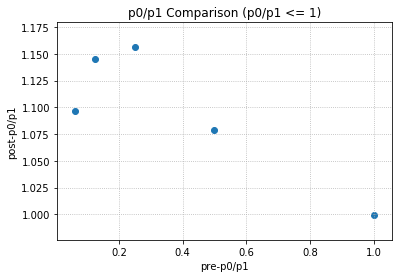

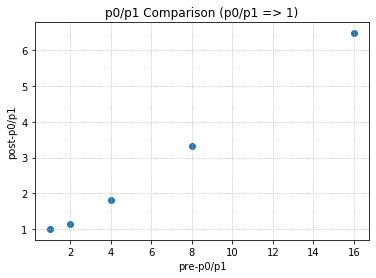

In [23]:
f = open('p0p1.data', 'rb')
p0p1 = pickle.load(f)
f.close()
f = open('p0p1_new.data', 'rb')
p0p1_new = pickle.load(f)
f.close()

plt.title('p0/p1 Comparison (p0/p1 <= 1)')
plt.scatter(p0p1[1][:5], p0p1_new[:5])
plt.xlabel('pre-p0/p1')
plt.ylabel('post-p0/p1')
plt.grid(which = 'both', linestyle = ':')
plt.show()

plt.title('p0/p1 Comparison (p0/p1 => 1)')
plt.scatter(p0p1[1][4:], p0p1_new[4:])
plt.xlabel('pre-p0/p1')
plt.ylabel('post-p0/p1')
plt.grid(which = 'both', linestyle = ':')
plt.show()

As we can see, p0/p1 always changes after convolutional encoding. p0/p1 after convolutional encoding(post-p0/p1) always become approximate to 1 when p0/p1 < 1 before convolutional encoding (pre-p0/p1), and post-p0/p1 is always become smaller when pre-p0/p1 > 1. This observation can be explained by Trellis diagram intuitively. In the Trellis diagram, when "1" is as input, the branch of maximum likelihood path will go down(or go straight), and when "0" is as input, the branch of maximum likelihood(ML) path will go up(or go straight). Thus, when pre-p0/p1 < 1 which means more "1"s are as inputs, the ML path will cover many lowest branches of which the outputs are "10"(which means p0/p1 = 1). Thus, the overall p0/p1 is approximate to 1.

When pre-p0/p1 > 1 which means more "0"s are as inputs, the ML path will cover many highest branches of which the outputs are "00". If "1" is as input, the ML path will go down and next go up until it touches the highest branch again due to more inputs "0". In this "recovering" process where the input is such as "1 - 0 - 0" (so that ML path goes back the hight branch again), the ratio of "1"s  which will be produced as output is higher compared with pre-p1. For example, if pre-p0/p1 = 16, assume 14 consecutive "0" are as inputs which starts from state "00", then 1 "1" as next input and 2 "0"s as the following outputs (pre-p0/p1 = 16). According to Trellis diagram, the post-p0/p1 = 5.8, which is approximate to the value in the firgue above.

Thus, the optimal decision rule for received data in viterbi decoding is calculated based on post p0/p1.

## Simulations

In this section, we run the simulations for transmitting bitstream data with a large length in differnt $\pi0/\pi1$. We observe BER performance between uncoded communication and the one with viterbi decoding in different Eb/N0s. 
### Verification for our simulation setup
First we verify our simulation setup. We compare the BER in different Eb/N0s between the simulation and analysis in uncoded communication. As we can see, the simulation curves provide good match with analytical curves, which shows our simulation setup is correct under the optimal decision rule.

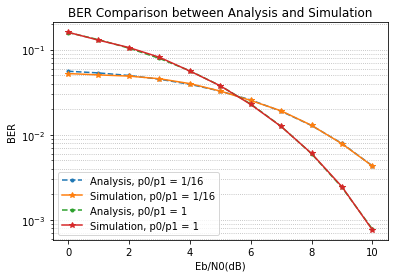

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import pickle
from scipy.stats import norm

f = open('simpleBER.data', 'rb')
simpleBER = pickle.load(f)
f.close()

SNR = []
sigma = []
P0P1 = [[ 1/17, 1/2],
        ['1/16', '1']]

sigma = [[],[]]

for i in range(0, 11):
    SNR.append(i)
    
for d in range (len(sigma)):
    for i in range(0, 11):
        sigma[d].append(sqrt((1-P0P1[0][d])/(2 * 10 ** (0.1 * SNR[i]))))

PE = [[], []]
for d in range (len(P0P1[0])):
    for i in range(len(SNR)):
        PE[d].append(P0P1[0][d] * (1 - norm.cdf(sigma[d][i] * log(P0P1[0][d]/(1 - P0P1[0][d])) + 1/(2*sigma[d][i]))) +\
                     (1 - P0P1[0][d])*norm.cdf(sigma[d][i] * log(P0P1[0][d]/(1 - P0P1[0][d])) - 1/(2*sigma[d][i])))                                                    

for d in range (0,2):
    plt.plot(SNR, PE[d], '--', marker = '.', label = 'Analysis, p0/p1 = '+ (P0P1[1][d]))
    plt.plot(SNR, simpleBER[d], '-', marker = '*', label = 'Simulation, p0/p1 = '+ (P0P1[1][d]))

plt.title('BER Comparison between Analysis and Simulation')
plt.xlabel('Eb/N0(dB)')
plt.ylabel('BER')
plt.yscale('log')
plt.grid(which = 'both', axis = 'y', linestyle = ':')
plt.legend()
plt.show()

### Simulation on Viterbi decoding

In [6]:
# The first row of thresh is used to produce original bitstream with different p0/p1, the second row is p0/p1,
# the last row is used for labeling.   
thresh = [[1/17, 1/2],\
          [1/16, 1],\
          ['1/16', '1']]

SNR = []
sigma = [[],[]]
for i in range(0, 11):
    SNR.append(i)
    for j in range(0, 2):
        # The standard deviation of Gaussian noise in different SNRs.
        sigma[j].append(sqrt((1-thresh[0][j])/(2 * 10 ** (0.1 * SNR[i]))))
    

simpleBER = [[],[]]
viterbiBER = [[],[]]

randList = np.random.random(10**7)
print("IN PROGRESS:0.00%", end = "\r")
for d in range(0,2):
    codeOriFull = []
    # produce input bitstream
    for m in range(len(randList)):
        if (randList[m] < thresh[0][d]): codeOriFull.append(0)
        else: codeOriFull.append(1)
                
    for t in range(0, 11):
        codeLen = int(10 ** (11/3 + t/3))
        codeOri = codeOriFull[:codeLen]
        
        # compute BER under uncoded communication
        codeR = simpleDecoder(codeOri, sigma[d][t], thresh[1][d])
        count = 0
        for i in range(0, len(codeOri)):
            if codeOri[i]!=codeR[i]: count += 1
        simpleBER[d].append(count/len(codeOri))
        
        # compute p0/p1 after convolutional encoder
        codeConv, codeTransT = convEncoder(codeOri)
        count0 = 0;
        count1 = 0;
        for i in range(len(codeTransT)):
            if codeTransT[i] == 0: count0 += 1
            else: count1 += 1
        r = count0/count1
        codeObs, codeTransR = noiseAdder(codeTransT, sigma[d][t], r)
        codeRecover = vitDec(codeObs, start_metric, state_machine)
        
        # compute BER under Viterbi decoding communication
        count = 0
        for i in range(0, len(codeOri)):
            if codeOri[i]!=codeRecover[i]: count += 1
        viterbiBER[d].append(count/len(codeOri))
        
        print("IN PROGRESS:{:.2f}%".format((11*d+t+1)/0.22), end="\r")

        
f = open('SNR.data', 'wb')
pickle.dump(SNR, f)
f.close()
f = open('thresh.data', 'wb')
pickle.dump(thresh, f)
f.close()
f = open('simpleBER.data', 'wb')
pickle.dump(simpleBER, f)
f.close()
f = open('viterbiBER.data', 'wb')
pickle.dump(viterbiBER, f)
f.close()

print('\nFINISH')

IN PROGRESS:100.00%
FINISH


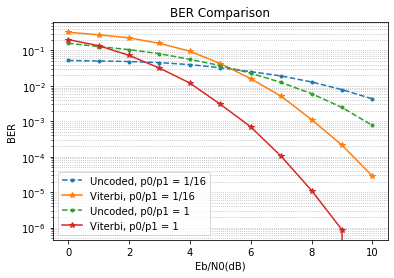

In [19]:
f = open('SNR.data', 'rb')
SNR = pickle.load(f)
f.close()
f = open('thresh.data', 'rb')
thresh = pickle.load(f)
f.close()
f = open('simpleBER.data', 'rb')
simpleBER = pickle.load(f)
f.close()
f = open('viterbiBER.data', 'rb')
viterbiBER = pickle.load(f)
f.close()

for i in range(0,2):
    plt.plot(SNR, simpleBER[i], '--', marker = '.', label = 'Uncoded, p0/p1 = '+ (thresh[2][i]))
    plt.plot(SNR, viterbiBER[i], '-', marker = '*', label = 'Viterbi, p0/p1 = '+ (thresh[2][i]))
plt.title('BER Comparison')
plt.xlabel('Eb/N0(dB)')
plt.ylabel('BER')
plt.yscale('log')
plt.grid(which = 'both', axis = 'y', linestyle = ':')
plt.legend()
plt.show()

## Testing on simulation time for Viterbi decoding
This section shows the simulation time in different bitstream length under Viterbi decoding. We are interested in testing the efficiency of viterbi decoding which is used for simulation.

Simulation time:0.03 secs
Simulation time:0.02 secs
Simulation time:0.15 secs
Simulation time:1.52 secs
Simulation time:49.63 secs
Simulation time:481.55 secs

FINISH


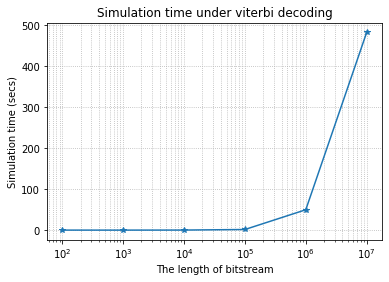

In [53]:
# The first row of thresh is used to produce original bitstream with different p0/p1, the second row is p0/p1,
# the last row is used for labeling.   
import numpy as np
import matplotlib.pyplot as plt
from math import *
import pickle
from scipy.stats import norm
from datetime import datetime
import time

thresh = 1/2
SNR = 6 
# The standard deviation of Gaussian noise in different SNRs.
sigma = sqrt((1-thresh)/(2 * 10 ** (0.1 * SNR)))
    
simpleBER = []
viterbiBER = []
bitstreamLength = []
simulationTime = []
for r in range (2,8):
    bitstreamLength.append(10**r)
    randList = np.random.random(10**r)
    codeOriFull = []
    # produce input bitstream
    for m in range(len(randList)):
        if (randList[m] < thresh): codeOriFull.append(0)
        else: codeOriFull.append(1)
    codeOri = codeOriFull
    start = time.time()
    # compute p0/p1 after convolutional encoder
    codeConv, codeTransT = convEncoder(codeOri)
    count0 = 0;
    count1 = 0;
    for i in range(len(codeTransT)):
        if codeTransT[i] == 0: count0 += 1
        else: count1 += 1
    r = count0/count1
    codeObs, codeTransR = noiseAdder(codeTransT, sigma, r)
    codeRecover = vitDec(codeObs, start_metric, state_machine)

    # compute BER under Viterbi decoding communication
    count = 0
    for i in range(0, len(codeOri)):
        if codeOri[i]!=codeRecover[i]: count += 1
    viterbiBER.append(count/len(codeOri))
    
    end = time.time()
    print("Simulation time:{:.2f}".format((end-start))+" secs")
    simulationTime.append((end-start))
print('\nFINISH')

plt.plot(bitstreamLength, simulationTime, '-', marker = '*')
plt.title('Simulation time under viterbi decoding')
plt.xlabel('The length of bitstream')
plt.ylabel('Simulation time (secs)')
plt.xscale('log')
plt.grid(which = 'both', linestyle = ':')
plt.show()

## Conclusion

The Viterbi decoding method uses the maximum likelihood decoding (MLD) algorithm, which finds the most likely pattern from the received data. In our project, using the Hidden Markov Model, viterbi decoding outperforms uncoded communication remarkably in most cases, when Eb/N0 of system is not too bad, as is shown in the plot above. This feature becomes even more significant when the ratio of '0's is high in the input bitstream. This result shows that viterbi decoding is a decent choice for digital communication.

Notice that this is just the typical example of a system using convolutional encoding and viterbi decoding techniques, since there are various types of convolutional encoding with different input-output bit ratios. More experiments could be done with plenty of time, for getting into extra details in this field.